In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from matplotlib import pyplot as plt
import seaborn as sns 
from sklearn.metrics import r2_score

In [2]:
user = "Shop" #"Colin"
if (user == "Colin"):
  wd = 'C:/Users/cjcar/Dropbox/MalariaAttribution/Data'
  repo = "" #to fill in
elif (user == "Tamma"):
  wd ='/Users/tammacarleton/Dropbox/MalariaAttribution/Data'
  repo = '/Users/tammacarleton/Dropbox/Works_in_progress/git_repos/falciparum'
elif (user == "Shop"):
  wd = '/Users/bublai/Dropbox/ruins_remote_sensing/malaria'
  repo = '/Users/bublai/Desktop/research/falciparum/'
else:
  wd = NA
  print('Script not configured for this user!')

In [3]:
df = pd.read_csv("/Users/bublai/Dropbox/ruins_remote_sensing/malaria/formatted-backup.csv")

In [8]:
count = 0
for i in df.Pf:
    if np.isnan(i):
        count+=1

In [9]:
count

1198633

In [7]:
df

,Unnamed: 0,OBJECTID,month,year,Pf,PfPR2,ppt,ppt2,R0,temp,temp2
0,1,65,Apr,1900,NaN,NaN,25.900001,672.500030,0.000000,15.600000,243.360012
1,2,65,Apr,1901,NaN,NaN,37.550001,1411.105088,0.000001,15.750000,248.065000
2,3,65,Apr,1902,NaN,NaN,21.550000,464.825009,0.000000,13.850000,191.825011
3,4,65,Apr,1903,NaN,NaN,84.050003,7067.465513,0.000000,14.650000,214.625003
4,5,65,Apr,1904,NaN,NaN,39.350000,1548.625029,0.000005,15.850000,251.225012
...,...,...,...,...,...,...,...,...,...,...,...
1207843,1207844,3609,Sep,2013,NaN,NaN,1.011111,1.965556,0.553776,22.133334,493.107796
1207844,1207845,3609,Sep,2014,NaN,NaN,9.166667,119.998896,0.556516,22.194445,496.438348
1207845,1207846,3609,Sep,2015,NaN,NaN,2.155556,10.960001,0.666648,22.961111,530.545012
1207846,1207847,3609,Sep,2016,NaN,NaN,0.522222,0.327778,0.588302,22.383334,504.339463


In [25]:
df.head()

,Unnamed: 0,OBJECTID,month,year,Pf,PfPR2,ppt,ppt2,R0,temp,temp2
0,1,65,Apr,1900,NaN,NaN,25.900001,672.500030,0.000000,15.60,243.360012
1,2,65,Apr,1901,NaN,NaN,37.550001,1411.105088,0.000001,15.75,248.065000
2,3,65,Apr,1902,NaN,NaN,21.550000,464.825009,0.000000,13.85,191.825011
3,4,65,Apr,1903,NaN,NaN,84.050003,7067.465513,0.000000,14.65,214.625003
4,5,65,Apr,1904,NaN,NaN,39.350000,1548.625029,0.000005,15.85,251.225012


In [26]:
df_pre = df[df.year < 1980]

In [27]:
df_post = df[df.year >= 1980]

In [46]:
avg_pre = df_pre.groupby('year').mean()
avg_post = df_post.groupby('year').mean()
avg_total = df.groupby('year').mean()

In [43]:
avg_pre

,Unnamed: 0,OBJECTID,Pf,PfPR2,ppt,ppt2,R0,temp,temp2
year,,,,,,,,,
1900,603866.0,1702.362251,20.750000,63.628750,81.634275,15636.716114,0.596985,23.113797,560.404487
1901,603867.0,1702.362251,NaN,NaN,78.699770,14504.869063,0.600620,23.189808,563.257429
1902,603868.0,1702.362251,37.000000,74.180000,81.472691,15959.100109,0.598714,23.099644,559.447566
1903,603869.0,1702.362251,24.000000,48.860000,81.249030,16865.320067,0.583670,22.966165,553.252803
1904,603870.0,1702.362251,19.500000,63.020000,81.897664,16523.598362,0.591590,23.039959,558.012619
...,...,...,...,...,...,...,...,...,...
1975,603941.0,1702.362251,74.811493,20.128222,82.052253,15500.478491,0.596398,22.895809,549.608408
1976,603942.0,1702.362251,113.008924,40.052669,79.822240,16009.115970,0.601320,23.262787,564.432751
1977,603943.0,1702.362251,45.031768,25.634056,84.804113,17107.652167,0.599815,23.126405,559.170892


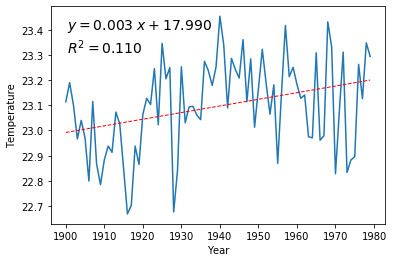

In [113]:
fig = plt.figure()
ax1 = fig.add_subplot()
ax1.set_ylabel('Temperature')
ax1.set_xlabel('Year')
x = avg_pre.index.values
y = avg_pre['temp']
plt.plot(x,y)
z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)

plt.plot(x, y_hat, "r--", lw=1)
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
     fontsize=14, verticalalignment='top')
plt.savefig('/Users/bublai/Dropbox/ruins_remote_sensing/malaria/temp_pre.png')

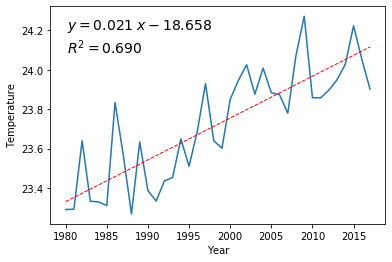

In [114]:
fig = plt.figure()
ax1 = fig.add_subplot()
ax1.set_ylabel('Temperature')
ax1.set_xlabel('Year')
x = avg_post.index.values
y = avg_post['temp']
plt.plot(x,y)
z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)

plt.plot(x, y_hat, "r--", lw=1)
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
     fontsize=14, verticalalignment='top')
plt.savefig('/Users/bublai/Dropbox/ruins_remote_sensing/malaria/temp_post.png')

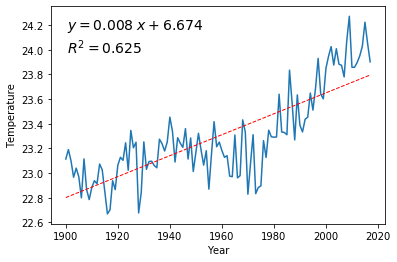

In [115]:
fig = plt.figure()
ax1 = fig.add_subplot()
ax1.set_ylabel('Temperature')
ax1.set_xlabel('Year')
x = avg_total.index.values
y = avg_total['temp']
plt.plot(x,y)
z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)

plt.plot(x, y_hat, "r--", lw=1)
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
     fontsize=14, verticalalignment='top')
plt.savefig('/Users/bublai/Dropbox/ruins_remote_sensing/malaria/temp_all.png')

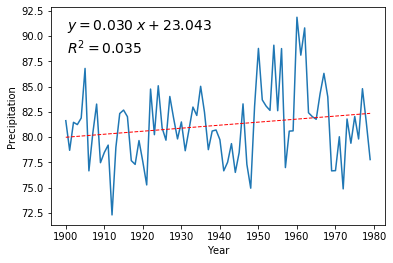

In [116]:
fig = plt.figure()
ax1 = fig.add_subplot()
ax1.set_ylabel('Precipitation')
ax1.set_xlabel('Year')
x = avg_pre.index.values
y = avg_pre['ppt']
plt.plot(x,y)
z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)

plt.plot(x, y_hat, "r--", lw=1)
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
     fontsize=14, verticalalignment='top')
plt.savefig('/Users/bublai/Dropbox/ruins_remote_sensing/malaria/ppt_pre.png')

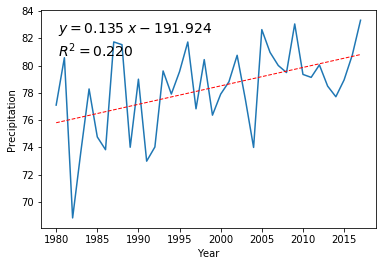

In [117]:
fig = plt.figure()
ax1 = fig.add_subplot()
ax1.set_ylabel('Precipitation')
ax1.set_xlabel('Year')
x = avg_post.index.values
y = avg_post['ppt']
plt.plot(x,y)
z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)

plt.plot(x, y_hat, "r--", lw=1)
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
     fontsize=14, verticalalignment='top')
plt.savefig('/Users/bublai/Dropbox/ruins_remote_sensing/malaria/ppt_post.png')

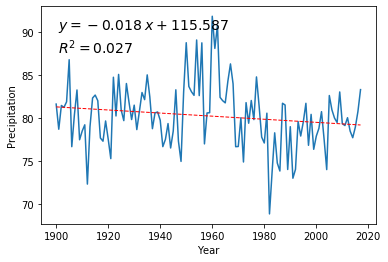

In [118]:
fig = plt.figure()
ax1 = fig.add_subplot()
ax1.set_ylabel('Precipitation')
ax1.set_xlabel('Year')
x = avg_total.index.values
y = avg_total['ppt']
plt.plot(x,y)
z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)

plt.plot(x, y_hat, "r--", lw=1)
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
     fontsize=14, verticalalignment='top')
plt.savefig('/Users/bublai/Dropbox/ruins_remote_sensing/malaria/ppt_all.png')